In [1]:
import numba, os, sys, time, pickle, resource, copy
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from sys import path

from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
import importlib

crobar_path = '/home/jplowman/research/solar-physics/codebase/crobar/python_modules'
path.append(crobar_path)
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import estimate_aia_error, search_fido_response, bindown2, get_limb, get_limb_occlusion
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission

path.append('../codebase')
from misc_io import get_croprs, get_map, get_bounds, bounds2grid

plt.rcParams.update({'font.size': 18,'figure.figsize':[20,12],'image.origin':'lower'})

In [2]:
gfac = 1.0/2.2
asec_cm = 1.49e13/(3600*180/np.pi) # An arcsecond from one AU

# Save files and arguments that need to go in the save file names:
save_dir = 'save'
magnetogram_dir = 'data'
emission_dir = 'save'

# note, the following two files need to have been created externally. 
magnetogram_name = 'hmi.m_45s.2020.04.28_11_13_30_TAI.magnetogram.fits'
emis_name = 'radloss_iswat_042820.fits'
alpha = 3/1.0e11
alphastr = str(round(alpha/1.0e-11,3))

date = '2020/04/28 11:13:30'
datestr = '20200428_111330'

footpoint_savefile = os.path.join(save_dir,'footpoints_'+datestr+'.npz')
loop_savefile = os.path.join(save_dir,'loops_'+datestr+'_'+alphastr+'.npz')
loopid_savefile = os.path.join(save_dir,'loopids_'+datestr+'_'+alphastr+'.npz')
emis_configfile = os.path.join(save_dir,'emconfig_'+'_'+datestr+'_'+alphastr+'.npz')
emis_savefile = os.path.join(save_dir,'em3d_'+emis_name[0:-4]+'_'+datestr+'_'+alphastr+'.npz')

newpoints = 0 or not(os.path.exists(footpoint_savefile)) # Generate new seed points
newtrace = 0 or not(os.path.exists(loop_savefile)) # Retrace field lines
newfilter = 0
newmatrix = 0 or not(os.path.exists(emis_configfile)) # Make new forward matrix

In [3]:
footpoint_config = dict(np.load(footpoint_savefile),allow_pickle=False)
loop_config = dict(np.load(loop_savefile),allow_pickle=False)
emis_config = dict(np.load(emis_configfile),allow_pickle=False)
emis_config['emis_name'] = emis_name

In [4]:
length_unit = u.Unit(str(footpoint_config['length_unit']))
pos_unit = u.Unit(str(footpoint_config['pos_unit']))

magnetogram_path = os.path.join(magnetogram_dir,str(footpoint_config['magnetogram_name']))
emis_path = os.path.join(emission_dir,str(emis_config['emis_name']))

In [5]:
cropr, cropr_emis = get_croprs(footpoint_config)
magnetogram = get_map(magnetogram_path, cropr)
emis_map = get_map(emis_path, cropr_emis)

In [6]:
rsun_cm = magnetogram.center.rsun.to(length_unit).value
footpoint_config['rsun_cm'] = rsun_cm

# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram, lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

In [7]:
bounds0, tracer_bounds = get_bounds(mag_coords, footpoint_config, loop_config)
# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,loop_config['dvox'],offsets=footpoint_config['bounds_offset'],pad=loop_config['vox_boundpad'])
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,loop_config['dvox']*loop_config['flt_dvox_fac'],offsets=footpoint_config['bounds_offset'])
vox0, dvox, nvox = vox_grid.origin, np.diag(vox_grid.fwd), vox_grid.dims
print(vox0, dvox, nvox)

[-1.64535924e+10 -1.69383135e+10 -4.22539514e+09] [14000000. 14000000. 14000000.] [2298 2399 1951]


In [8]:
limb_mask = get_limb(vox_grid, rsun_cm)

In [9]:
loopid_info = dict(np.load(loopid_savefile))
loopids = loopid_info['voxel_loopids']
voxel_loop_lengths = loopid_info['voxel_loop_lengths']

In [10]:
fieldlines_filter = [loop_config['fieldlines_filter'][loop_config['fieldline_indices']==i] for i in range(0,loop_config['fieldline_indices'][-1]+1)]
lengths_filter = [loop_config['lengths_filter'][loop_config['fieldline_indices']==i] for i in range(0,loop_config['fieldline_indices'][-1]+1)]
nloops = len(lengths_filter)

In [11]:
lfracs_eval = np.array([0.01, 0.03, 0.06, 0.10, 0.15, 0.21, 0.28, 0.36, 0.45, 1-0.45, 1-0.36, 1-0.28, 1-0.21, 1-0.15, 1-0.1, 1-0.06, 1-0.03, 1-0.01])
nlfrac = len(lfracs_eval)

In [12]:
bfields = np.zeros([nloops, nlfrac, 3])
eval_coords = np.zeros([nlfrac,3])
for i in range(0,nloops):
	coords0 = fieldlines_filter[i]
	lengths0 = lengths_filter[i]
	lengths = lfracs_eval*np.max(lengths0)
	for j in range(0,3): eval_coords[:,j] = np.interp(lengths, lengths0, coords0[:,j])
	for j in range(0,nlfrac): bfields[i,j,:] = forcefree_field.compute_lff_field(None, eval_coords[j], mag_coords, mag, alpha)

In [13]:
for i in range(0,nvox[2]): loopids[:,:,i][limb_mask[:,:,i]==False] = nloops+1

In [14]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline

nlmax = loopid_info['lmax_scal']+1
nlbins2 = nlmax
lbin_edges2 = np.linspace(0,1,num=nlbins2+1)
lbin_cents2 = 0.5*(lbin_edges2[0:nlbins2]+lbin_edges2[1:nlbins2+1])
smooth_rad = 1.5
segment_volumes = copy.deepcopy(lengths_filter)
for i in range(0,nloops):
	bmag = np.nansum(bfields[i]**2,axis=1)**0.5
	bmag_smooth = gaussian_filter(bmag,smooth_rad,mode='nearest')
	segment_volumes[i] = CubicSpline(lfracs_eval,1.0/bmag_smooth)(lbin_cents2)

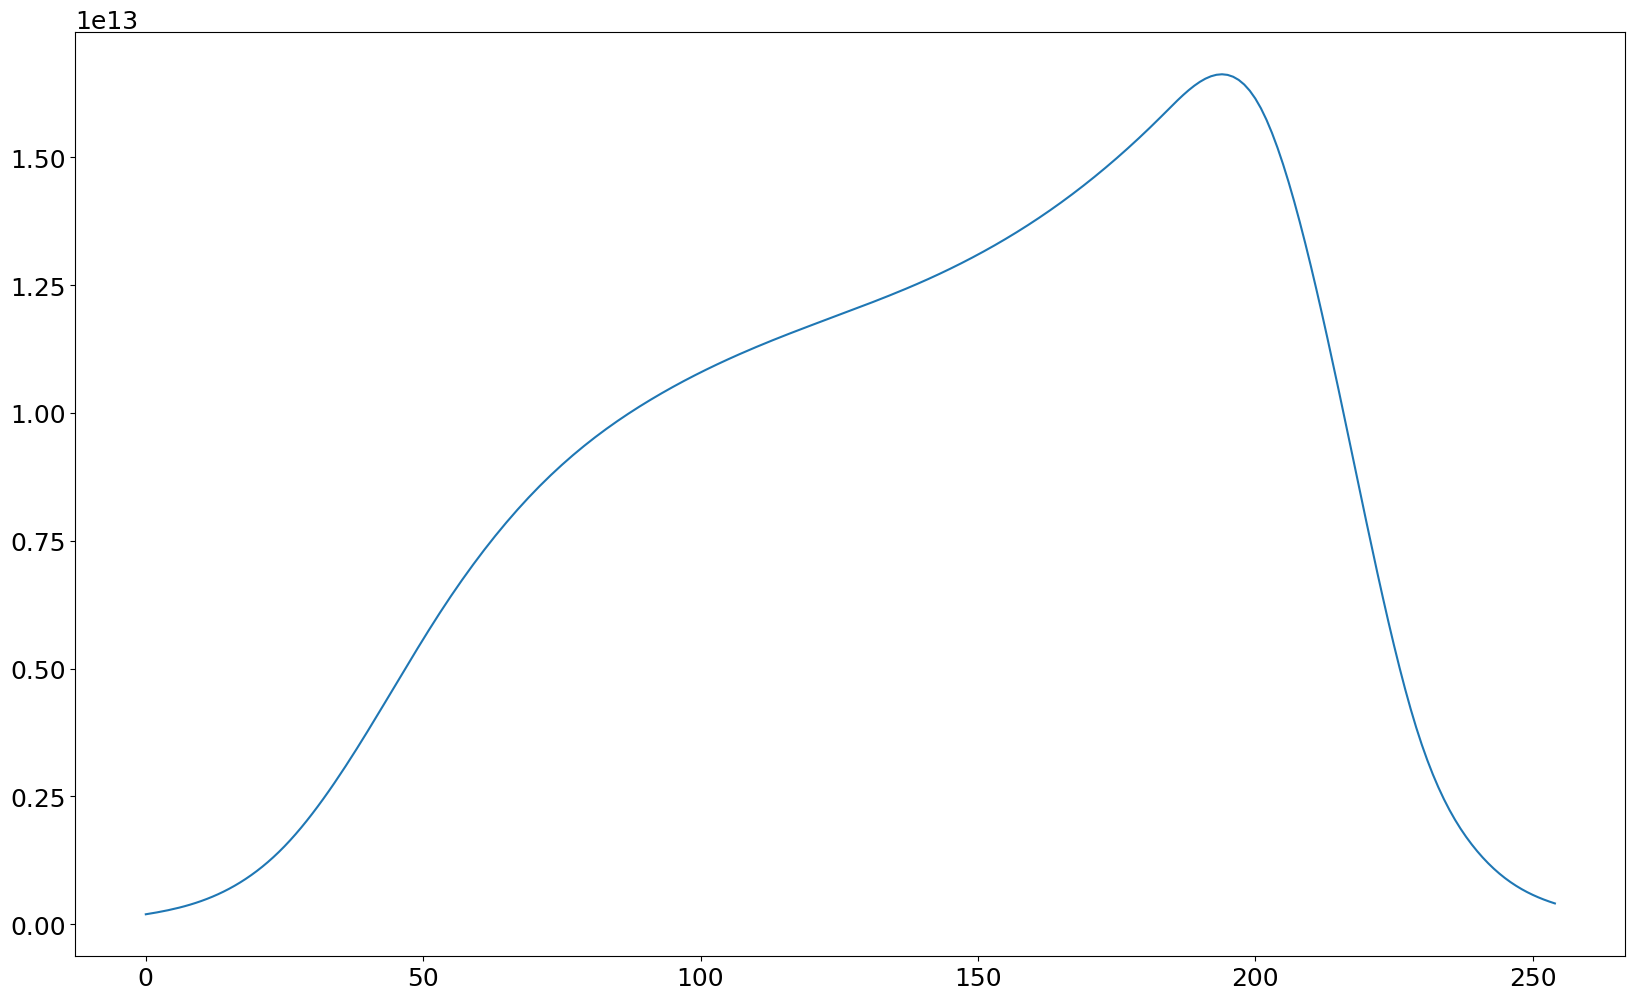

In [15]:
plt.plot(segment_volumes[5646])

In [16]:
loopvols = np.zeros(nloops+2)
for i in range(0,loopid_info['voxel_loopids'].shape[2]):
	loopvols += np.bincount(loopid_info['voxel_loopids'][:,:,i].flatten(),minlength=nloops+2)

In [17]:
loopvols=np.clip(loopvols[0:nloops],1,None)

In [18]:
segment_relareas = copy.deepcopy(segment_volumes)
segment_heights = copy.deepcopy(segment_volumes)
loop_amaxes = np.zeros(nloops)
for i in range(0,nloops): 
	segment_volumes[i] *= loopvols[i]/np.nansum(segment_volumes[i])
	loop_amaxes[i] = np.nanmax(segment_volumes[i])
	segment_relareas[i] = segment_volumes[i]/loop_amaxes[i]
	coords = fieldlines_filter[i].T
	heights = (coords[0]**2+coords[1]**2+(rsun_cm+coords[2])**2)**0.5 - rsun_cm
	segment_heights[i] = np.interp(lbin_cents2*np.max(lengths_filter[i]), lengths_filter[i], heights)

In [19]:
area_norms = loopvols[0:nloops]*np.prod(dvox)/loopid_info['looplengths'][0:nloops]/loop_amaxes

In [24]:
loop_area_savefile = os.path.join(save_dir,'loop_areas_'+datestr+'_'+alphastr+'.npz')

In [25]:
loop_area_config = {'lbin_cents':lbin_cents2,
					'segment_relareas':segment_relareas,
					'segment_heights':segment_heights,
					'loop_amaxes':loop_amaxes,
					'area_norms':area_norms}

np.savez_compressed(loop_area_savefile,**loop_area_config)

In [26]:
h = 1.0e-6 # erg/cm3/s
d = 1.0e8 # 1 Mm
l = 100e8 # 100 Mm
dt = 200 # s

In [27]:
loopid_info['loop_volumes'] = loop_areas['area_norms']*loop_areas['loop_amaxes']*loopid_info['looplengths'][0:nloops]

2e+22